# Training

## Setup

In [1]:
import torch
import torchvision
from torchvision import datasets, transforms
import pandas as pd
from torch.utils.data import random_split 
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
#from torch.autograd import Variable


In [2]:
if torch.cuda.is_available():
    device = torch.device('cuda')
elif torch.backends.mps.is_available():
    device = torch.device('mps')
else:
    device = torch.device('cpu')
#torch.backends.cudnn.enabled = False
val_size = 5000
test_size = 5000
batch_size = 128
num_workers = 4
pin_memory = False if device == torch.device('cpu') else True

# transform = transforms.Compose([transforms.ToTensor()])

## Potential changes - Markus

# Normalize input images to [-1, 1]
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5,), std=(0.5,))
])


# Downloading MNIST again :) Training (60k) and test(5k) + val(5k) split
train_loader = torch.utils.data.DataLoader(datasets.CIFAR10('./CIFAR_data',
                                            download=True,
                                            train=True,
                                            transform=transform),
                                            batch_size=batch_size,
                                            shuffle=True, num_workers=num_workers,
                                            pin_memory=pin_memory,
                                            drop_last=True)

test_dataset = datasets.CIFAR10('./CIFAR_data',
                               download=True,
                               train=False,
                               transform=transform)

val_dataset, test_dataset = random_split(test_dataset, [val_size, test_size])

# Test set to compare with DDPM paper
test_loader = torch.utils.data.DataLoader(test_dataset,
                                            batch_size=batch_size,
                                            shuffle=False, num_workers=num_workers,
                                            pin_memory=pin_memory)

# Validation set so we can keep track of approximated FID score while training
validation_loader = torch.utils.data.DataLoader(val_dataset,
                                            batch_size=batch_size,
                                            shuffle=False, num_workers=num_workers,
                                            pin_memory=pin_memory)
    

Files already downloaded and verified
Files already downloaded and verified


In [3]:
# # Sets up alpha_bar for training and test so alpha_bar_t = alpha_bar[t]
# T = 1000
# beta_start, beta_end = [1e-4, 2e-02]
# beta = torch.linspace(beta_start, beta_end, T)
# alpha = 1-beta
# alpha_bar = alpha.clone()
# for e in range(T-1):
#     alpha_bar[e+1] *= alpha_bar[e]

# alpha = alpha.view((T, 1, 1, 1)).to(device)
# beta = beta.view((T, 1, 1, 1)).to(device)
# alpha_bar = alpha_bar.view((T, 1, 1, 1)).to(device)


### Potential changes - Markus
T = 1000
beta_start, beta_end = 1e-4, 2e-2
beta = torch.linspace(beta_start, beta_end, T)  # Linear noise schedule
alpha = 1.0 - beta
alpha_bar = torch.cumprod(alpha, dim=0)  # Cumulative product for alpha_bar

# Reshape for broadcasting (if required for your model)
alpha = alpha.view((T, 1, 1, 1)).to(device)
beta = beta.view((T, 1, 1, 1)).to(device)
alpha_bar = alpha_bar.view((T, 1, 1, 1)).to(device)


## Model

In [ ]:
class UNET(torch.nn.Module):
    def __init__(self):
        super(UNET, self).__init__()
        channels = [32, 64, 128, 256]
        self.convs = nn.ModuleList([
            nn.Sequential(
                nn.Conv2d(4, channels[0], kernel_size=3, padding=1),  # (batchsize, 32, 28, 28)
                nn.ReLU(),
            ),
            nn.Sequential(
                nn.MaxPool2d(2),  # (batchsize, 32, 14, 14)
                nn.Conv2d(channels[0], channels[1], kernel_size=3, padding=1),  # (batchsize, 64, 14, 14)
                nn.ReLU(),
            ),
            nn.Sequential(
                nn.MaxPool2d(2),  # (batchsize, 64, 7, 7)
                nn.Conv2d(channels[1], channels[2], kernel_size=3, padding=1),  # (batchsize, 128, 7, 7)
                nn.ReLU(),
            ),
            nn.Sequential(
                nn.MaxPool2d(2, padding=1),  # (batchsize, 128, 4, 4)
                nn.Conv2d(channels[2], channels[3], kernel_size=3, padding=1),  # (batchsize, 256, 4, 4)
                nn.ReLU(),
            )
        ])

        self.tconvs = nn.ModuleList([
            nn.Sequential(
                nn.ConvTranspose2d(channels[3], channels[2], kernel_size=3, 
                                   stride=2, padding=1, output_padding=0),   # (batchsize, 128, 7, 7)
                nn.ReLU()
            ),
            nn.Sequential(
                nn.ConvTranspose2d(channels[2]*2, channels[1], kernel_size=3,
                                   stride=2, padding=1, output_padding=1),   # (batchsize, 64, 14, 14)
                nn.ReLU()
            ),
            nn.Sequential(
                nn.ConvTranspose2d(channels[1]*2, channels[0], kernel_size=3, 
                                   stride=2, padding=1, output_padding=1),   # (batchsize, 32, 28, 28)
                nn.ReLU()
            ),
            nn.Sequential(
                nn.Conv2d(channels[0]*2,channels[0],kernel_size=3,padding=1),  # (batchsize, 32, 28, 28)
                nn.ReLU(),
                nn.Conv2d(channels[0],3,kernel_size=1) # (batchsize, 1, 28, 28)
            )      
        ])

    def forward(self, x, t):
        x_trans = torch.cat((x, t), dim=-3)
        signal = x_trans
        signals = []

        for i, conv in enumerate(self.convs):
            # print(f"conv {i}")
            signal = conv(signal)
            # print(signal.shape)
            if i < len(self.convs)-1:
                signals.append(signal)
                
        for i, tconv in enumerate(self.tconvs):
            # print(f"tconv {i}")
            # print(f"signal shape: {signal.shape}")
            if i == 0:
                signal = tconv(signal)
            else:
                signal = torch.cat((signal, signals[-i]), dim=-3)
                signal = tconv(signal)
        return signal

## Training loop

In [17]:
#from UNET import UNET
epochs = 200
model = UNET()
model.to(device)
model.train()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
criterion = torch.nn.MSELoss()
running_loss = 0

In [19]:
for epoch in range(epochs):
    for e, data in enumerate(train_loader):
        x0, _ = data
        x0 = x0.to(device)
        t = torch.randint(1, T+1, (batch_size,)).to(device)
        eps = torch.randn(batch_size, 1, 32, 32).to(device)
        # print(eps.shape)
        
        xt = torch.sqrt(alpha_bar[t-1]) * x0 + torch.sqrt(1 - alpha_bar[t-1]) * eps
        #print(x0.shape)
        print(t.shape)
        print(t.view(batch_size, 1, 1, 1).expand(batch_size, 3, 32, 32).shape)
        print(xt.shape)
        loss = criterion(eps, model(xt, t.view(batch_size, 1, 1, 1).expand(batch_size, 1, 32, 32)))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()

        if e % 100 == 99:
            print(f'{epoch, e+1}, Average_loss: {running_loss/100:.3f}')
            running_loss = 0.0
    if epoch % 10 == 9:
        torch.save(model.state_dict(), f"DDPM_CIFAR_{epoch+1}.pth")

torch.Size([128])
torch.Size([128, 3, 32, 32])
torch.Size([128, 3, 32, 32])


RuntimeError: Sizes of tensors must match except in dimension 1. Expected size 9 but got size 32 for tensor number 1 in the list.

# Sampling

In [ ]:
with torch.inference_mode():
    model.eval()
    batch_size = 1
    xt = torch.randn(batch_size, 1, 32, 32).to(device)

    for t in torch.arange(T, 0, -1):
        print(t)
        t = t.to(device)
        z = torch.randn(batch_size, 1, 32, 32).to(device) if t > 1 else torch.zeros(batch_size, 1, 32, 32).to(device)
        xt_new = 1 / torch.sqrt(alpha[t - 1]) * (xt - (1 - alpha[t - 1])/(torch.sqrt(1 - alpha_bar[t - 1])) * 
                                                    model(xt, t.view(batch_size, 1, 1, 1).expand(batch_size, 1, 32, 32))) + torch.sqrt(beta[t-1]) * z
        xt = xt_new
        

tensor(1000)
tensor(999)
tensor(998)
tensor(997)
tensor(996)
tensor(995)
tensor(994)
tensor(993)
tensor(992)
tensor(991)
tensor(990)
tensor(989)
tensor(988)
tensor(987)
tensor(986)
tensor(985)
tensor(984)
tensor(983)
tensor(982)
tensor(981)
tensor(980)
tensor(979)
tensor(978)
tensor(977)
tensor(976)
tensor(975)
tensor(974)
tensor(973)
tensor(972)
tensor(971)
tensor(970)
tensor(969)
tensor(968)
tensor(967)
tensor(966)
tensor(965)
tensor(964)
tensor(963)
tensor(962)
tensor(961)
tensor(960)
tensor(959)
tensor(958)
tensor(957)
tensor(956)
tensor(955)
tensor(954)
tensor(953)
tensor(952)
tensor(951)
tensor(950)
tensor(949)
tensor(948)
tensor(947)
tensor(946)
tensor(945)
tensor(944)
tensor(943)
tensor(942)
tensor(941)
tensor(940)
tensor(939)
tensor(938)
tensor(937)
tensor(936)
tensor(935)
tensor(934)
tensor(933)
tensor(932)
tensor(931)
tensor(930)
tensor(929)
tensor(928)
tensor(927)
tensor(926)
tensor(925)
tensor(924)
tensor(923)
tensor(922)
tensor(921)
tensor(920)
tensor(919)
tensor(918)
ten

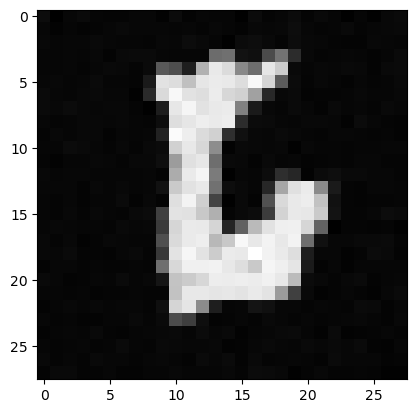

In [21]:
plt.imshow(xt[0][0].cpu().detach().numpy(), cmap="grey")